# Automobile Credit Risk Prediction:

## Objective:
Predict whether a loan applicant is likely to default on a loan.


## 1. Importing the necessory Libraries:

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import itertools
import time

from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesRegressor, VotingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve



import warnings
warnings.filterwarnings('ignore')

## 2. Exploratory Data Analysis (EDA):

In [5]:
train = pd.read_csv('2. Data\Train_Dataset.csv')
test = pd.read_csv('2. Data\Test_Dataset.csv')

In [6]:
# Drop duplicates
train.drop_duplicates()
test.drop_duplicates()

#Shape of dataframe
print(" Shape of training dataframe: ", train.shape)
print(" Shape of testing dataframe: ", test.shape)

 Shape of training dataframe:  (121856, 40)
 Shape of testing dataframe:  (80900, 39)


In [7]:
# Checking the sample data
train.head(3)

,ID,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,...,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Default
0,12142509,6750,0.0,0.0,1.0,0.0,0.0,61190.55,3416.85,Alone,...,Yes,Yes,Self-employed,0.568066,0.478787,NaN,0.0186,63.0,NaN,0
1,12138936,20250,1.0,0.0,1.0,NaN,0.0,15282,1826.55,Alone,...,Yes,Yes,Government,0.563360,0.215068,NaN,NaN,NaN,NaN,0
2,12181264,18000,0.0,0.0,1.0,0.0,1.0,59527.35,2788.2,Alone,...,Yes,Yes,Self-employed,NaN,0.552795,0.329655,0.0742,277.0,0.0,0


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121856 entries, 0 to 121855
Data columns (total 40 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ID                          121856 non-null  int64  
 1   Client_Income               118249 non-null  object 
 2   Car_Owned                   118275 non-null  float64
 3   Bike_Owned                  118232 non-null  float64
 4   Active_Loan                 118221 non-null  float64
 5   House_Own                   118195 non-null  float64
 6   Child_Count                 118218 non-null  float64
 7   Credit_Amount               118224 non-null  object 
 8   Loan_Annuity                117044 non-null  object 
 9   Accompany_Client            120110 non-null  object 
 10  Client_Income_Type          118155 non-null  object 
 11  Client_Education            118211 non-null  object 
 12  Client_Marital_Status       118383 non-null  object 
 13  Client_Gender 

It seems that the a lot of columns datatype is incorrect and also there are alot of columnns with null values. so, lets tackle first the datatypes.

### Handling Data Types:

In [11]:
for i, col in enumerate(list(train.columns)):
    print(col, train[col].unique(), train[col].dtype)
    print('-' * 100)

ID [12142509 12138936 12181264 ... 12103937 12170623 12105610] int64
----------------------------------------------------------------------------------------------------
Client_Income ['6750' '20250' '18000' ... '13140' '9764.1' '12840.75'] object
----------------------------------------------------------------------------------------------------
Car_Owned [ 0.  1. nan] float64
----------------------------------------------------------------------------------------------------
Bike_Owned [ 0.  1. nan] float64
----------------------------------------------------------------------------------------------------
Active_Loan [ 1.  0. nan] float64
----------------------------------------------------------------------------------------------------
House_Own [ 0. nan  1.] float64
----------------------------------------------------------------------------------------------------
Child_Count [ 0.  1.  2. nan  3.  4.  5.  7.  8. 10.  6. 19. 12. 14.  9.] float64
----------------------------------

In [12]:
# Clean
train['Client_Income'] = train['Client_Income'].str.replace('[^0-9.]', '', regex=True)
train['Credit_Amount'] = train['Credit_Amount'].str.replace('[^0-9.]', '', regex=True)
train['Loan_Annuity'] = train['Loan_Annuity'].str.replace('[^0-9.]', '', regex=True)
train['Population_Region_Relative'] = train['Population_Region_Relative'].str.replace('[^0-9.]', '', regex=True)
train['Age_Days'] = train['Age_Days'].str.replace('[^0-9.]', '', regex=True)
train['Employed_Days'] = train['Employed_Days'].str.replace('[^0-9.]', '', regex=True)
train['Registration_Days'] = train['Registration_Days'].str.replace('[^0-9.]', '', regex=True)
train['ID_Days'] = train['ID_Days'].str.replace('[^0-9.]', '', regex=True)
train['Score_Source_3'] = train['Score_Source_3'].str.replace('[^0-9.]', '', regex=True)



# Convert to correct DTypes
train['Client_Income'] = pd.to_numeric(train['Client_Income'], errors='coerce')
train['Credit_Amount'] = pd.to_numeric(train['Credit_Amount'], errors='coerce')
train['Loan_Annuity'] = pd.to_numeric(train['Loan_Annuity'], errors='coerce')
train['Population_Region_Relative'] = pd.to_numeric(train['Population_Region_Relative'], errors='coerce')
train['Age_Days'] = pd.to_numeric(train['Age_Days'], errors='coerce')
train['Employed_Days'] = pd.to_numeric(train['Employed_Days'], errors='coerce')
train['Registration_Days'] = pd.to_numeric(train['Registration_Days'], errors='coerce')
train['ID_Days'] = pd.to_numeric(train['ID_Days'], errors='coerce')
train['Score_Source_3'] = pd.to_numeric(train['Score_Source_3'], errors='coerce')

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121856 entries, 0 to 121855
Data columns (total 40 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ID                          121856 non-null  int64  
 1   Client_Income               102336 non-null  float64
 2   Car_Owned                   118275 non-null  float64
 3   Bike_Owned                  118232 non-null  float64
 4   Active_Loan                 118221 non-null  float64
 5   House_Own                   118195 non-null  float64
 6   Child_Count                 118218 non-null  float64
 7   Credit_Amount               38718 non-null   float64
 8   Loan_Annuity                94358 non-null   float64
 9   Accompany_Client            120110 non-null  object 
 10  Client_Income_Type          118155 non-null  object 
 11  Client_Education            118211 non-null  object 
 12  Client_Marital_Status       118383 non-null  object 
 13  Client_Gender 

### Handling Null Values:

In [15]:
null = train.isnull().sum()
pct_null = (train.isnull().mean()) * 100

null_df = pd.concat([null,pct_null], axis=1, keys=['Total Missing', 'Percent Missing']).reset_index()
null_df = null_df.rename(columns={'index': 'column name'})

null_df

,column name,Total Missing,Percent Missing
0,ID,0,0.000000
1,Client_Income,19520,16.018908
2,Car_Owned,3581,2.938715
3,Bike_Owned,3624,2.974002
4,Active_Loan,3635,2.983029
5,House_Own,3661,3.004366
6,Child_Count,3638,2.985491
7,Credit_Amount,83138,68.226431
8,Loan_Annuity,27498,22.565980
9,Accompany_Client,1746,1.432839


Almost all variables have null values. So the best apporach is **iterative imputation.** But before that we need to encode the categorical data and tackle the Data inconsistancies.

In [17]:
categorical_data = []
numerical_data = []

for i, col in enumerate(list(train.columns)):
    if train[col].dtype == 'object':
        categorical_data.append(col)
    else:
        numerical_data.append(col)

In [18]:
for i in categorical_data:
    print(train[i].value_counts())
    print('-' * 50)

Accompany_Client
Alone       97409
Relative    15748
Partner      4516
Kids         1334
Others        987
Group         104
##             12
Name: count, dtype: int64
--------------------------------------------------
Client_Income_Type
Service            61028
Commercial         27764
Retired            21043
Govt Job            8303
Student                8
Unemployed             6
Maternity leave        2
Businessman            1
Name: count, dtype: int64
--------------------------------------------------
Client_Education
Secondary             83911
Graduation            28819
Graduation dropout     3960
Junior secondary       1455
Post Grad                66
Name: count, dtype: int64
--------------------------------------------------
Client_Marital_Status
M    87349
S    17404
D     7556
W     6074
Name: count, dtype: int64
--------------------------------------------------
Client_Gender
Male      78463
Female    40977
XNA           3
Name: count, dtype: int64
-------------------

In [19]:
# Accompany_Client Data Inconsistencies
cluster_mapping = {"##" : "Others", "Group" : "Others"}

# Update the "Accompany_Client" column with the new cluster labels
train["Accompany_Client"] = train["Accompany_Client"].replace(cluster_mapping)

# Check the value_counts after replacing
train["Accompany_Client"].value_counts()

Accompany_Client
Alone       97409
Relative    15748
Partner      4516
Kids         1334
Others       1103
Name: count, dtype: int64

In [20]:
# Client_Income_Type Data Inconsistency
# In Client_Income_Type column, [Student, Unemployed, Maternity leave, and Businessman] seems to be outlier.
# So we will first replace it with null then impute with iterative imputation later.
train['Client_Income_Type'] = train['Client_Income_Type'].replace(['Student', 'Unemployed', 'Maternity leave', 'Businessman'], np.nan)

In [21]:
# Client_Gender Data Inconsistency
# In Client_Gender column, XNA seems to be an outlier.
# So we will first replace it with null then impute with iterative imputation later.
train['Client_Gender'] = train['Client_Gender'].replace('XNA', np.nan)

In [22]:
# list(filter(lambda x: x!= 'Default', numerical_data))

In [23]:
categorical_data

['Accompany_Client',
 'Client_Income_Type',
 'Client_Education',
 'Client_Marital_Status',
 'Client_Gender',
 'Loan_Contract_Type',
 'Client_Housing_Type',
 'Client_Occupation',
 'Client_Permanent_Match_Tag',
 'Client_Contact_Work_Tag',
 'Type_Organization']

In [24]:
X = train.drop(columns=['Default'])
y = train['Default']

X.shape

(121856, 39)

In [25]:
X.isnull().sum()

ID                                 0
Client_Income                  19520
Car_Owned                       3581
Bike_Owned                      3624
Active_Loan                     3635
House_Own                       3661
Child_Count                     3638
Credit_Amount                  83138
Loan_Annuity                   27498
Accompany_Client                1746
Client_Income_Type              3718
Client_Education                3645
Client_Marital_Status           3473
Client_Gender                   2416
Loan_Contract_Type              3651
Client_Housing_Type             3687
Population_Region_Relative     43231
Age_Days                       10582
Employed_Days                  10631
Registration_Days              10589
ID_Days                        12853
Own_House_Age                  80095
Mobile_Tag                         0
Homephone_Tag                      0
Workphone_Working                  0
Client_Occupation              41435
Client_Family_Members           2410
C

## Machine Learning Model:

### Random Forest Classifier:

In [28]:
start_overall = time.time()

# -------------------------------
# Step 1: Drop high-missing columns
# -------------------------------
threshold = 0.5  # Drop columns with more than 50% missing
missing_pct = train.isnull().mean()
cols_to_drop = missing_pct[missing_pct > threshold].index
train_reduced = train.drop(columns=cols_to_drop)

# -------------------------------
# Step 2: Split target and features
# -------------------------------
X = train_reduced.drop(columns=['Default', 'ID'])  # Drop ID too if not useful
y = train_reduced['Default']

# -------------------------------
# Step 3: Identify categorical & numerical columns
# -------------------------------
categorical_col = X.select_dtypes(include='object').columns.tolist()
numerical_col = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# -------------------------------
# Step 4: Ordinal Encode categoricals
# -------------------------------
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[categorical_col] = encoder.fit_transform(X[categorical_col])

# -------------------------------
# Step 5: Iterative Imputer on full data
# -------------------------------
imputer = IterativeImputer(estimator=DecisionTreeRegressor(max_depth=5), max_iter=5, random_state=42)

X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
# -------------------------------
# Step 6: Train/Test Split and Modeling
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, stratify=y, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# -------------------------------
# Step 7: Evaluation
# -------------------------------
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

end_overall = time.time()

print(f'Over all time: {end_overall - start_overall:.2f} seconds')


              precision    recall  f1-score   support

           0       0.93      1.00      0.96     22403
           1       0.99      0.08      0.15      1969

    accuracy                           0.93     24372
   macro avg       0.96      0.54      0.56     24372
weighted avg       0.93      0.93      0.90     24372

Over all time: 355.71 seconds


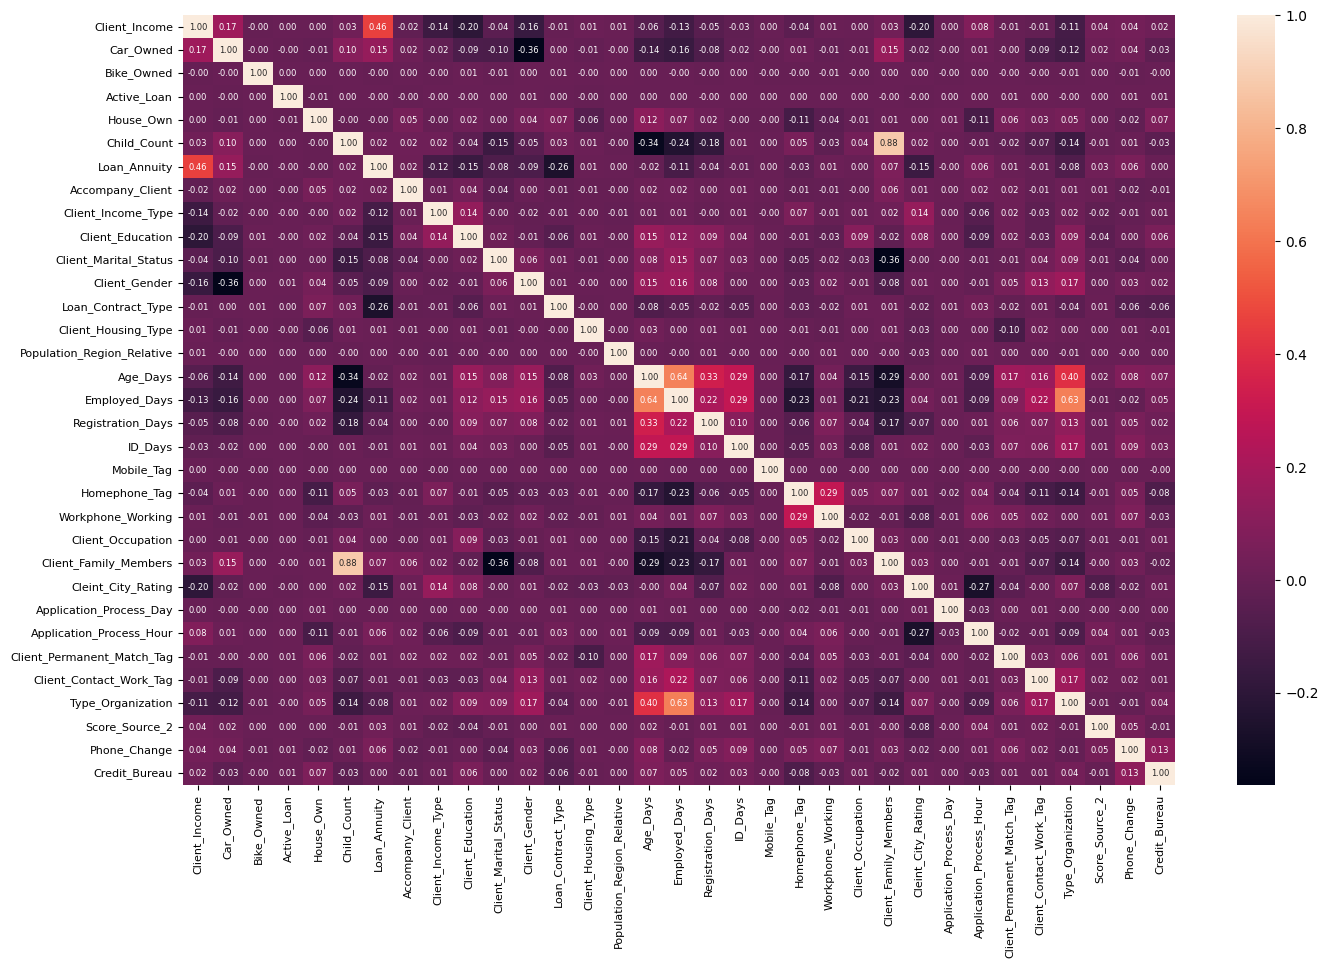

In [29]:
# Correlation with heat map
corr_overall = X_imputed.corr()

plt.figure(figsize=(16,10))

a = sns.heatmap(corr_overall, annot=True, annot_kws={"size": 6}, fmt='.2f')
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=90, fontsize=8)
roty = a.set_yticklabels(a.get_yticklabels(), fontsize=8)

### SMOTE + Random Forest Classifier:

In [31]:
start_overall = time.time()

# Drop columns with more than 30% missing values
missing_pct = train.isnull().mean()
cols_to_drop = missing_pct[missing_pct > 0.3].index
train = train.drop(columns=cols_to_drop)

# Update your feature lists accordingly
categorical_col = [col for col in categorical_data if col in train.columns and col != 'ID']
numerical_col = [col for col in numerical_data if col in train.columns and col != 'Default']

# Split features and target
X = train.drop(columns=['Default'])
y = train['Default']

# Column transformer: encode categoricals
encoder = ColumnTransformer([('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_col)], remainder='passthrough')

# Full pipeline: encoder → imputer → SMOTE → classifier
pipeline = ImbPipeline([
    ('encode', encoder),
    ('impute', IterativeImputer(estimator=DecisionTreeRegressor(max_depth=5), max_iter=5, random_state=42)),
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Fit the pipeline
start_train = time.time()
pipeline.fit(X_train, y_train)
end_train = time.time()
print(f"Model Training Time: {end_train - start_train:.2f} seconds")

# Predict probabilities
start_pred = time.time()
y_proba = pipeline.predict_proba(X_test)[:, 1]
end_pred = time.time()
print(f'Probability Prediction Time: {end_pred - start_pred:.2f} seconds')

# Threshold tuning — maximize F1
start_eval = time.time()

prec, rec, thresh = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-9)
best_threshold = thresh[np.argmax(f1_scores)]
print(f"Best threshold: {best_threshold:.3f}")
# Predict with best threshold
y_pred = (y_proba >= best_threshold).astype(int)
# Report
print(classification_report(y_test, y_pred))

end_eval = time.time()
print(f'Evaluation and Threshold Tuning Time: {end_eval - start_eval:.2f} seconds')

end_overall = time.time()

print(f'Total Time: {end_overall - start_overall:.2f} seconds')

Model Training Time: 279.18 seconds
Probability Prediction Time: 1.83 seconds
Best threshold: 0.220
              precision    recall  f1-score   support

           0       0.94      0.89      0.91     28003
           1       0.22      0.36      0.27      2461

    accuracy                           0.84     30464
   macro avg       0.58      0.63      0.59     30464
weighted avg       0.88      0.84      0.86     30464

Evaluation and Threshold Tuning Time: 0.05 seconds
Total Time: 281.48 seconds


In [32]:
X.columns

Index(['ID', 'Client_Income', 'Car_Owned', 'Bike_Owned', 'Active_Loan',
       'House_Own', 'Child_Count', 'Loan_Annuity', 'Accompany_Client',
       'Client_Income_Type', 'Client_Education', 'Client_Marital_Status',
       'Client_Gender', 'Loan_Contract_Type', 'Client_Housing_Type',
       'Age_Days', 'Employed_Days', 'Registration_Days', 'ID_Days',
       'Mobile_Tag', 'Homephone_Tag', 'Workphone_Working',
       'Client_Family_Members', 'Cleint_City_Rating',
       'Application_Process_Day', 'Application_Process_Hour',
       'Client_Permanent_Match_Tag', 'Client_Contact_Work_Tag',
       'Type_Organization', 'Score_Source_2', 'Phone_Change', 'Credit_Bureau'],
      dtype='object')

### SMOTETomek + Random Forest Classifier:

In [34]:
from imblearn.combine import SMOTETomek


start_overall = time.time()

# Step 1: Drop columns with >30% missing
missing_pct = train.isnull().mean()
cols_to_drop = missing_pct[missing_pct > 0.3].index
train = train.drop(columns=cols_to_drop)

# Step 2: Update feature lists
categorical_col = [col for col in categorical_data if col in train.columns and col != 'ID']
numerical_col = [col for col in numerical_data if col in train.columns and col != 'Default']

# Step 3: Define X and y
X = train.drop(columns=['Default'])
y = train['Default']

# Step 4: Column transformer
encoder = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_col)
    ],
    remainder='passthrough'
)

# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Step 6: Define pipeline with SMOTETomek
pipeline = ImbPipeline([
    ('encode', encoder),
    ('impute', IterativeImputer(estimator=DecisionTreeRegressor(max_depth=5), max_iter=5, random_state=42)),
    ('resample', SMOTETomek(random_state=42)),
    ('model', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Step 7: Fit pipeline
start_train = time.time()
pipeline.fit(X_train, y_train)
end_train = time.time()
print(f"Model Training Time: {end_train - start_train:.2f} seconds")

# Step 8: Predict probabilities
start_pred = time.time()
y_proba = pipeline.predict_proba(X_test)[:, 1]
end_pred = time.time()
print(f"Probability Prediction Time: {end_pred - start_pred:.2f} seconds")

# Step 9: Threshold tuning
start_eval = time.time()
prec, rec, thresh = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-9)
best_threshold = thresh[np.argmax(f1_scores)]
print(f"Best threshold: {best_threshold:.3f}")

# Step 10: Predict with best threshold
y_pred = (y_proba >= best_threshold).astype(int)
print(classification_report(y_test, y_pred))

end_eval = time.time()
print(f"Evaluation and Threshold Tuning Time: {end_eval - start_eval:.2f} seconds")

end_overall = time.time()
print(f"Total Time: {end_overall - start_overall:.2f} seconds")


Model Training Time: 428.36 seconds
Probability Prediction Time: 2.06 seconds
Best threshold: 0.250
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     28003
           1       0.26      0.29      0.27      2461

    accuracy                           0.87     30464
   macro avg       0.60      0.61      0.60     30464
weighted avg       0.88      0.87      0.88     30464

Evaluation and Threshold Tuning Time: 0.02 seconds
Total Time: 430.72 seconds
